# HAMILTONIQ: COMPREHENSIVE OPTIMIZATION AND
BENCHMARKING FOR MIXER HAMILTONIAN IN QAOA WITH
ERROR MITIGATION


*Teammembers*

## Introduction:

Quantum computing, with its potential to solve certain problems exponentially faster than classical computers, has been the subject of intense research and development. One promising application of quantum computing lies in optimization problems, which are ubiquitous in various fields such as logistics, finance, and machine learning. However, solving these problems on a quantum computer poses significant challenges due to the nascent stage of quantum hardware and the complexity of quantum algorithms.

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical algorithm that has been proposed as a practical method to solve combinatorial optimization problems on near-term, noisy intermediate-scale quantum (NISQ) devices. QAOA operates by approximating the ground state of a problem Hamiltonian \(H_P\), which encodes the optimization problem to be solved. The QAOA ansatz state is given by:

\begin{equation}
    |\psi(\beta, \gamma)\rangle = U(\beta, \gamma)|s\rangle,
\end{equation}

where $|\psi\rangle$ is the initial state, and $U(\beta, \gamma)$ is the QAOA unitary. Despite its potential, the performance of QAOA and the mechanisms underlying its success are not yet fully understood.

In this paper, we present a comprehensive study of QAOA, focusing on its performance, the mechanism of its operation, and its implementation on near-term quantum devices. We provide a detailed analysis of the algorithm's performance on different problem instances and investigate the role of quantum interference in the success of QAOA. Furthermore, we discuss practical considerations for implementing QAOA on current quantum hardware, including the impact of noise and the choice of initial states.

Our findings contribute to the understanding of QAOA and provide valuable insights for its application on near-term quantum devices. We hope that our work will guide future research in this area and facilitate the practical use of quantum computing for optimization problems.




### Description of QAOA

add here

### Applications in portfolio optimization
QAOA aims to minimize the expectation value of a cost function. Classically, this function is given by \cite{QAOA2021}
\begin{equation}
    F(z_1, z_2, ..., z_n) = q \sum_{i, j = 1}^n z_i z_j \sigma_{ij} - (1 - q) \sum_{i = 1}^n z_i \mu_i, z_i = 0, 1,
\end{equation}

where $z_i$ is a binary variable indicating the presence of a given stock in the portfolio, $q$ is the risk tolerance of an investor, $\mu_i$ is the expected return value of a given stock $z_i$, and $\sigma_{ij}$ is the covariance matrix of the stock returns. When mapped to a Hamiltonian operator, this cost function takes the form
\begin{equation}
    \hat{F} = \sum_{i = 1}^{n - 1} \sum_{j = i + 1}^n W_{ij} \hat{Z}_i \hat{Z}_j - \sum_{i = 1}^n w_i \hat{Z}_i + c
\end{equation}
where $W_{ij} = q \sigma_{ij} + A$ and $w_i = (1 - q) \mu _i + A(2B - n) - q \sum_{j = 1}^n \sigma_{ij}$
The expectation value is taken with respect to the parametrized wave function given by:
\begin{equation}
    \left|\psi_{\gamma, \beta}\right\rangle = \hat{U}_M (\beta _p)e^{-i \gamma _p \hat{F}} ... \hat{U}_M (\beta _2) e^{-i \gamma _p \hat{F}} \hat{U} _M (\beta _1) e^{-i \gamma _1 \hat{F}_A} \left|\psi\right\rangle_M
\end{equation}
The unitary operators $\hat{U}_M(\beta _p)$ are the mixing matrices.
The standard implementation consists of a series of $\hat{X}$ gates applied to each qubit given by $e^{i \beta \sum_{i = 1}^n \hat{X}_i}$. The improved versions makes use of the system's underlying symmetries in order to simplify the computation of the expectation value. These can take on various forms, as described in section \ref{sec:XY-Mixer Formulation}.


## Idea


Explain what your idea is. Whats your approach in tackling this problem. Explain in detail the general idea, the steps and also why this should lead to a better solution


## Solution

### "Naive"/default solution

Describe how the naive solution is implemented. If the default solution already has some optimization in it, explain what it is.
And then implement the solution in code. Explain what parameters can be changed in the code below.

In [27]:
# Importing all the parts we will need.
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram


import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi


# Your code here: Implementation of the naive solution

### Your solution

Explain which paramateres can be changed in the code below, how to get different results.

In [28]:

# Your code here: Implementation of the good solution

## Solving combinatorial optimization problems using QAOA


### Combinatorial Optimization Problem


In [29]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import XXPlusYYGate
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile
import numpy as np
import qiskit
import math
from qiskit.quantum_info import Statevector

print(qiskit.__qiskit_version__)

#nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

{'qiskit-terra': '0.23.3', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.42.1', 'qiskit-nature': None, 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': None}


In [30]:
# Grid/Graph creator
def QAOA_Graph_Creator(label="standard"):
    graph = nx.Graph()
    if label == "standard":
        graph.add_nodes_from([0, 1, 2, 3])
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2), (4,3)])
    elif label == "hardware":
        graph = nx.grid_2d_graph(3, 3)
    elif label == "Three-Regular":
        graph.add_nodes_from(range(8))  # This will add nodes 0 to 7
        graph.add_edges_from([(0, 1), (0, 2), (0, 3),
                              (1, 4), (1, 5),
                              (2, 6), (2, 7),
                              (3, 4), (3, 7),
                              (4, 6),
                              (5, 6), (5, 7)])
    elif label == "SK": # SK = Sherrington-Kirkpatrick
        num_nodes = 7
        graph = nx.complete_graph(num_nodes)
    return graph


### The Problem Unitary (Hamiltonian)

In [31]:
"""
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw("mpl")
"""

'\ngamma = Parameter("$\\gamma$")\nqc_p = QuantumCircuit(N_QUBITS)\nfor pair in list(graph.edges()):  # pairs of nodes\n    qc_p.rzz(2 * gamma, pair[0], pair[1])\n    qc_p.barrier()\n\nqc_p.decompose().draw("mpl")\n'

In [32]:
# X-Mixer
def x_mixer(qc, n, b):
    for i in range(n):
        qc.rx(2 * b, i)
    return qc

# XY-Mixer
def xy_mixer_ring(qc, n, b):
    for i in range(n-1):
        qc.append(XXPlusYYGate(2*b, 0), [i, i+1])
    qc.append(XXPlusYYGate(2*b, 0), [0, n-1])
    return qc

# Full-Mixer
def xy_mixer_full(qc, n, b):
    for i in range(n):
        for j in range(i+1, n):
            qc.append(XXPlusYYGate(2 * b), [i, j])
    return qc

# Parity-Mixer
def xy_mixer_parity(qc, n, b):
    for i in range(n-1)[::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    for i in range(n-1)[1::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    return qc


### The Mixing Unitary (Hamiltonian)

In [33]:


# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
"""

adjacency = nx.adjacency_matrix(graph).todense()

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
qc_mix = xy_mixer_parity(qc_mix, N_QUBITS, beta)
qc_mix.draw("mpl")
"""

'\n\nadjacency = nx.adjacency_matrix(graph).todense()\n\nbeta = Parameter("$\\beta$")\nqc_mix = QuantumCircuit(N_QUBITS)\nqc_mix = xy_mixer_parity(qc_mix, N_QUBITS, beta)\nqc_mix.draw("mpl")\n'

## Initial State

In [34]:
"""
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw("mpl")
"""

'\nqc_0 = QuantumCircuit(N_QUBITS)\nfor i in range(N_QUBITS):\n    qc_0.h(i)\n\nqc_0.draw("mpl")\n'

### The QAOA circuit

In [35]:
"""

qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

qc_qaoa.decompose().draw("mpl")
"""

'\n\nqc_qaoa = QuantumCircuit(N_QUBITS)\nqc_qaoa.append(qc_0, range(N_QUBITS))\nqc_qaoa.append(qc_p, range(N_QUBITS))\nqc_qaoa.append(qc_mix, range(N_QUBITS))\n\nqc_qaoa.decompose().decompose().draw()\n\nqc_qaoa.decompose().draw("mpl")\n'

In [36]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary

        qc = xy_mixer_ring(qc, nqubits, beta[layer_index])

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        qc = transpile(qc, backend)
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [37]:
from scipy.optimize import minimize

#N_QUBITS = 5
shots = 2048
graph = QAOA_Graph_Creator("SK")
expectation = get_expectation(graph, shots)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -10.35546875
       x: [ 9.211e-01  1.047e+00]
    nfev: 28
   maxcv: 0.0

        ┌───┐                                                                 »
   q_0: ┤ H ├─■────────────■────────────■─────────────────────────■───────────»
        ├───┤ │ZZ(2.0946)  │            │                         │           »
   q_1: ┤ H ├─■────────────┼────────────┼────────────■────────────┼───────────»
        ├───┤              │ZZ(2.0946)  │            │ZZ(2.0946)  │           »
   q_2: ┤ H ├──────────────■────────────┼────────────■────────────┼───────────»
        ├───┤                           │ZZ(2.0946)               │           »
   q_3: ┤ H ├───────────────────────────■─────────────────────────┼───────────»
        ├───┤                                                     │ZZ(2.0946) »
   q_4: ┤ H ├─────────────────────────────────────────────────────■───────────»
        ├───┤                                                                 »
   q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
        ├───┤                           

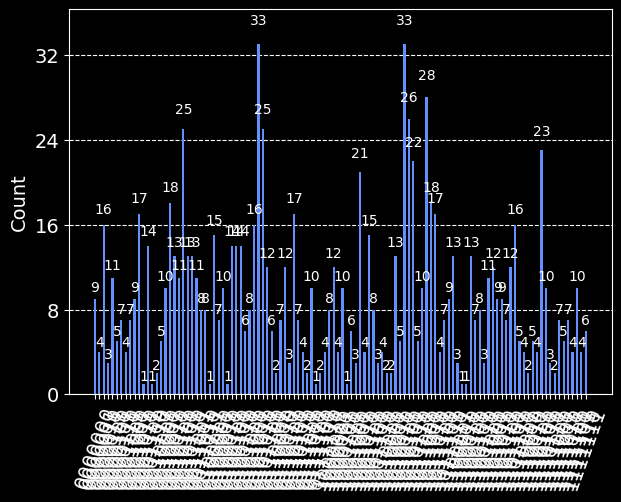

In [38]:
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit.execute_function import execute

backend = Aer.get_backend('aer_simulator')
backend.shots = shots

qc_res = create_qaoa_circ(graph, res.x)
print(qc_res.draw())

counts = execute(qc_res, backend).result().get_counts()
#counts = backend.run(qc_res, seed_simulator=5).result().get_counts()
plot_histogram(counts)



In [39]:
for key, val in counts.items():
    if(val>=80):
        print(str(key)+" "+str(val))

In [40]:
#xmixer
#01011 110
#10100 100
#xy mixer ring
#11010 103
#01010 145
#10101 135

#xy full
#10101 148
#00001 142
#01010 167
#11110 157

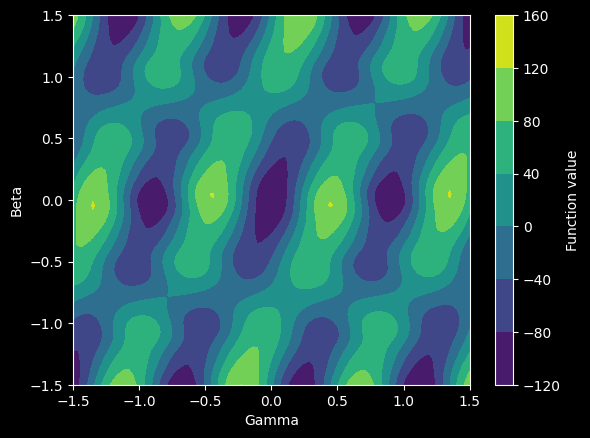

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import pi

# Define the range of gamma and beta values
gamma_values = np.linspace(-1.5, 1.5, 100)
beta_values = np.linspace(-1.5, 1.5, 100)

# Initialize an array to store the function values
fun_values = np.zeros((len(gamma_values), len(beta_values)))

def compute_expectation_sv(sv, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    for i in range(2**7):
        a = f"{bin(i)[2:]:0>{7}}"
        obj = maxcut_obj(a, graph)
        avg += obj * sv[i]
    return avg

def create_qaoa_circ_sv(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary

        qc = x_mixer(qc, nqubits, beta[layer_index])
    return qc

# Run the QAOA circuit for each pair of gamma and beta values
def execute_circ(theta):
    qc = create_qaoa_circ_sv(graph, theta)
    sv = Statevector(qc)
    return compute_expectation_sv(sv, graph)
for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        theta = [beta, gamma]
        expe = execute_circ(theta)
        fun_values[i, j] = expe

# Create the contour plot
plt.contourf(gamma_values, beta_values, fun_values)
plt.colorbar(label='Function value')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.show()


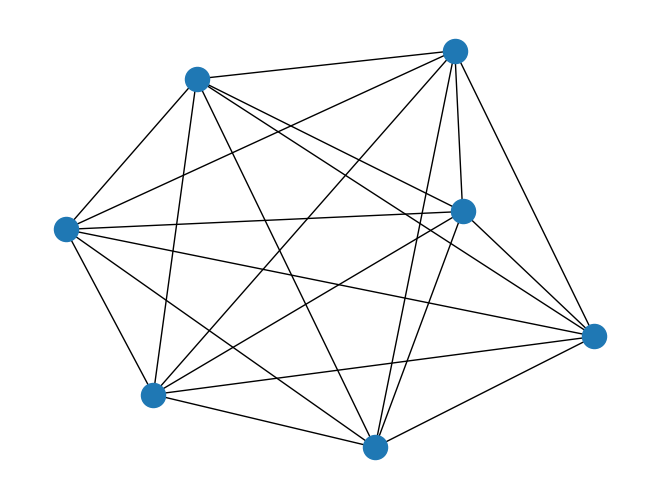

In [42]:
nx.draw(graph)

## Results

Analyse both solutions the naive and yours, and show what is better.
This can both be done theoretically (like Big O notation) or also some concrete results.
If possible show below some graphs to compare the 2 solutions helping to explain what makes your solution so good.

In [43]:

# Your code here: Use code to show graphs